In [87]:
import pandas as pd
import numpy as np

from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\himan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Read the trainSet CSV file 
data = pd.read_csv('D:\\Adthena\\trainSet.csv')

In [5]:
data

,Text,Classes
0,yew hedge,1221
1,fire detection shop,19
2,cheap couch roll,398
3,extra watermelon gum,1108
4,used generators for sale uk,213
...,...,...
606818,plastic storage tower,1103
606819,flaine accommodation,589
606820,how much is the blue lagoon in iceland,38
606821,hff31014,485


# Pre-Processing of Data

In [6]:
#Clean the combined Reviews
def review_cleaned(text):
    review_text_cleaned1 = text
    split = re.sub("[^a-zA-Z]", " ",text)
    tokens = nltk.word_tokenize(split)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] 
    removed_1_text = [t for t in lemmas if len(t) > 1]
    review_text_cleaned1 = ' '.join(removed_1_text)
    return(review_text_cleaned1)

# clean text data
import re,nltk
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
data["Cleaned_Text"] = data["Text"].apply(lambda x: review_cleaned(x))

In [7]:
data = data.drop(columns='Text')
data = data.reset_index(drop=True)

In [8]:
#Count the Number of Null Values
data.isnull().values.sum()

0

In [9]:
data.isnull().sum()

Classes         0
Cleaned_Text    0
dtype: int64

# Keras-Training Models: For Classification 1419 classes.

In [10]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [11]:
data["Classes"].value_counts()

54      623
1026    609
39      609
291     608
533     607
       ... 
173      16
1309     14
554      14
826      10
587       4
Name: Classes, Length: 1419, dtype: int64

In [12]:
textBlob_df = data

In [13]:
# most frequent words used
MAX_NB_WORDS = 50000
# Max number of words in each text
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(textBlob_df['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 57062 unique tokens.


In [14]:
X = tokenizer.texts_to_sequences(textBlob_df['Cleaned_Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (606823, 250)


In [15]:
Y = pd.get_dummies(textBlob_df['Classes']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (606823, 1419)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(546140, 250) (546140, 1419)
(60683, 250) (60683, 1419)


In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate

In [18]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1419, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 491526 samples, validate on 54614 samples
Epoch 1/20
491526/491526 [==============================] - 2469s 5ms/step - loss: 4.1219 - accuracy: 0.3240 - val_loss: 2.5077 - val_accuracy: 0.5157
Epoch 2/20
491526/491526 [==============================] - 2456s 5ms/step - loss: 2.3248 - accuracy: 0.5289 - val_loss: 2.1698 - val_accuracy: 0.5563
Epoch 3/20
491526/491526 [==============================] - 3927s 8ms/step - loss: 1.9831 - accuracy: 0.5750 - val_loss: 2.0615 - val_accuracy: 0.5761
Epoch 4/20
491526/491526 [==============================] - 5714s 12ms/step - loss: 1.8111 - accuracy: 0.5992 - val_loss: 2.0178 - val_accuracy: 0.5826
Epoch 5/20
491526/491526 [==============================] - 4273s 9ms/step - loss: 1.7003 - accuracy: 0.6157 - val_loss: 1.9912 - val_accuracy: 0.5903
Epoch 6/20
491526/491526 [==============================] - 2641s 5ms/step - loss: 1.6237 - accuracy: 0.6272 - val_loss: 1.9768 - val_accuracy: 0.5895
Epoch 7/20
491526/491526 [===============

In [20]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

60683/60683 [==============================] - 70s 1ms/step
Test set
  Loss: 1.931
  Accuracy: 0.605


# Testing On New Data : candidateTestSet

In [73]:
#Read the candidateTestSet file
testData = pd.read_csv('D:\\Adthena\\candidateTestSet.csv')

In [74]:
testData.head(5)

,Text
0,twister picnic blanket
1,best stop smoking app
2,phosphorus fertiliser
3,tattoo books
4,child's desk chair


In [75]:
testData["Cleaned_Text"] = testData["Text"].apply(lambda x: review_cleaned(x))

In [76]:
testData.head(4)

,Text,Cleaned_Text
0,twister picnic blanket,twister picnic blanket
1,best stop smoking app,best stop smoking app
2,phosphorus fertiliser,phosphorus fertiliser
3,tattoo books,tattoo book


In [77]:
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(testData['Cleaned_Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21405 unique tokens.


In [78]:
X2_test = tokenizer.texts_to_sequences(testData['Cleaned_Text'].values)
X2_test = pad_sequences(X2_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X2_test.shape)

Shape of data tensor: (67424, 250)


In [79]:
values = model.predict(x=[X2_test])

In [80]:
import numpy as np
inverted_other = []
for i in range(len(values)):
    try:
        inverted_other.append([np.argmax(values[i, :])])
    except ValueError:
        inverted_other.append('<>')

        

data_df = pd.DataFrame()
data_df['Predicted_Value'] = inverted_other
testData["Classes"] = data_df["Predicted_Value"]
testData['Classes'] = testData['Classes'].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(str)
testData

,Text,Cleaned_Text,Classes
0,twister picnic blanket,twister picnic blanket,380
1,best stop smoking app,best stop smoking app,832
2,phosphorus fertiliser,phosphorus fertiliser,366
3,tattoo books,tattoo book,1102
4,child's desk chair,child desk chair,703
...,...,...,...
67419,visible learning for teachers,visible learning teacher,760
67420,ikea sheepskin rug,ikea sheepskin rug,232
67421,best employment lawyers,best employment lawyer,560
67422,express furniture repairs,express furniture repair,1325


In [89]:
testData = testData.drop(columns='Cleaned_Text')

In [90]:
testData.to_csv("candidateTestSetResult.csv")

In [91]:
testData.head(4)

,Text,Classes
0,twister picnic blanket,380
1,best stop smoking app,832
2,phosphorus fertiliser,366
3,tattoo books,1102


In [81]:
X2_test

array([[   0,    0,    0, ..., 6507, 2944,  652],
       [   0,    0,    0, ...,  370, 1556,  193],
       [   0,    0,    0, ...,    0, 8021, 4862],
       ...,
       [   0,    0,    0, ...,    3, 1273, 2309],
       [   0,    0,    0, ...,  659,  152,   71],
       [   0,    0,    0, ..., 1629, 1211,   54]])

# Evaluation Metrics on Validation Data

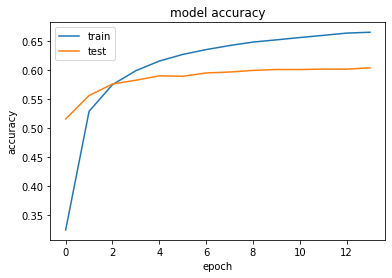

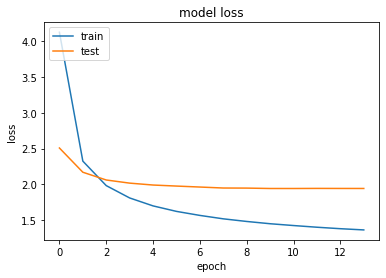

In [82]:

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

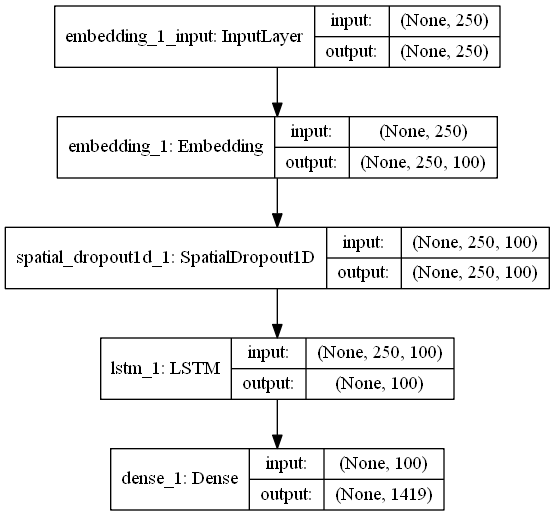

In [83]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [92]:
values1 = model.predict(x=[X_test])
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

60683/60683 [==============================] - 75s 1ms/step
Test set
  Loss: 1.931
  Accuracy: 0.605


In [93]:
import numpy as np
inverted_other = []
for i in range(len(values1)):
    try:
        inverted_other.append([np.argmax(values1[i, :])])
    except ValueError:
        inverted_other.append('<>')

actual = []
for i in range(len(Y_test)):
    try:
        #print('decoded', label_encoder.inverse_transform([argmax(values[i, :])]))
        actual.append([np.argmax(Y_test[i, :])])
    except ValueError:
        actual.append('<>')
        

data_df = pd.DataFrame()
data_df['Actual_Value'] = actual
data_df['Predicted_Value'] = inverted_other

In [94]:
data_df.head(10)

,Actual_Value,Predicted_Value
0,[71],[141]
1,[12],[308]
2,[552],[1168]
3,[1412],[1412]
4,[250],[250]
5,[744],[110]
6,[1009],[1009]
7,[33],[33]
8,[28],[28]
9,[1087],[536]


In [97]:
data_df['Actual_Value'] = data_df['Actual_Value'].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(str)
data_df['Predicted_Value'] = data_df['Predicted_Value'].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(str)

In [98]:
from sklearn.metrics import accuracy_score
print('Validation accuracy is',accuracy_score(data_df['Actual_Value'],data_df['Predicted_Value']))

Validation accuracy is 0.604699833561294


In [101]:
# Importing metrics for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(data_df['Actual_Value'], data_df['Predicted_Value']))
print(confusion_matrix(data_df['Actual_Value'], data_df['Predicted_Value']))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.80      0.61      0.69        46
           1       0.49      0.76      0.60        33
          10       0.48      0.50      0.49        46
         100       0.10      0.15      0.12        20
        1000       0.78      0.73      0.75        63
        1001       0.73      0.79      0.76        52
        1002       0.61      0.67      0.64        66
        1003       0.68      0.76      0.72        51
        1004       0.00      0.00      0.00        25
        1005       0.63      0.83      0.72        46
        1006       0.58      0.80      0.67        50
        1007       0.73      0.70      0.71        53
        1008       0.25      0.06      0.10        17
        1009       0.87      0.76      0.81        59
         101       0.66      0.81      0.73        58
        1010       0.33      0.24      0.28        38
        1011       0.35      0.36      0.36        36
        1012       0.66    

[[28  0  0 ...  0  0  0]
 [ 0 25  0 ...  0  0  0]
 [ 0  0 23 ...  0  0  0]
 ...
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0 32  0]
 [ 0  0  1 ...  0  0 45]]


[0.         0.         0.         ... 0.24242424 1.         1.        ]
[0.00000000e+00 8.57378401e-04 1.61582852e-03 ... 9.98994229e-01
 9.99422918e-01 1.00000000e+00]
[1419 1418 1417 ...    2    1    0]
0.17931074970646282


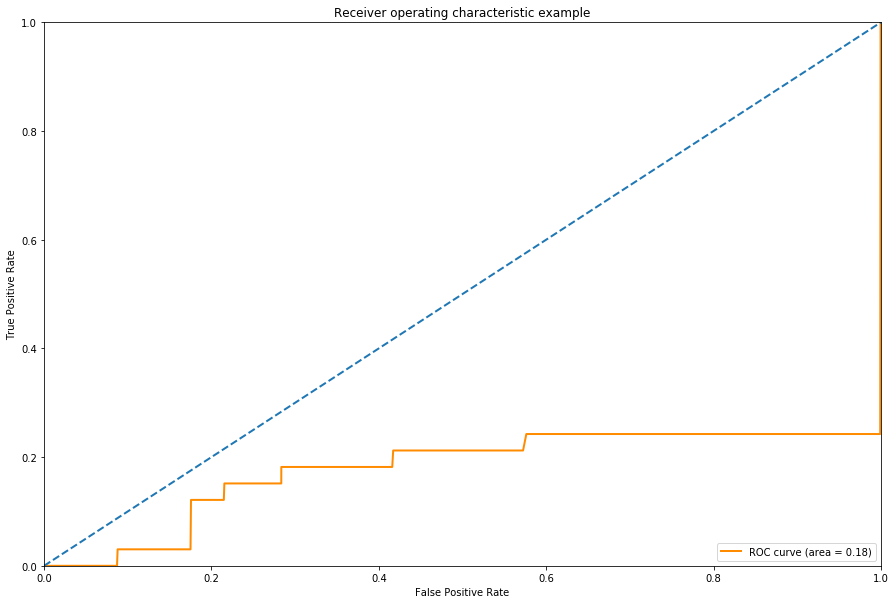

In [99]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

fpr, tpr, thresholds = roc_curve(data_df['Actual_Value'].astype(int),data_df['Predicted_Value'].astype(int), pos_label = 1)
print(tpr)
print(fpr)
print(thresholds)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()